In [1]:
import re
import os
import sys
import cv2

os.environ['PYTHONPATH'] += "/Users/cosmos/Desktop/parleg-alpha/RealTimeObjectDetection/Tensorflow/models"
sys.path.append( "/Users/cosmos/Desktop/parleg-alpha/RealTimeObjectDetection/Tensorflow/models")

import numpy as np
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format
from PIL import Image
from matplotlib.image import imread

#functions
def clean_ocr(data):
    for i in data:
        m = re.search("^[a-zA-Z0-9_]*$", i)
    if m==None:
        data.remove(i)
        
    data2 = [i for i in data if not i.isalpha()]

    data3 = []

    for k in data2:
        if len(k)==5:
            data3 = data3 + [k]
            
    return data3



/opt/homebrew/Caskroom/miniforge/base/envs/TOD/lib/python3.9/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/homebrew/Caskroom/miniforge/base/envs/TOD/lib/python3.9/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ["[Errno 2] The file to load file system plugin from does not exist.: '/opt/homebrew/Caskroom/miniforge/base/envs/TOD/lib/python3.9/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so'"]
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/homebrew/Caskroom/miniforge/base/envs/TOD/lib/python3.9/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/homebrew/Caskroom/miniforge/base/envs/TOD/lib/python3.9/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused b

In [2]:
CURRENT_WORKSPACE_NAME = '/workspace'
ROOT_PATH = '/Users/cosmos/Desktop/parleg-alpha/RealTimeObjectDetection'
WORKSPACE_PATH = ROOT_PATH+'/Tensorflow/'+CURRENT_WORKSPACE_NAME
SCRIPTS_PATH = ROOT_PATH+'/Tensorflow/scripts'
APIMODEL_PATH = ROOT_PATH+'/Tensorflow/models'
ANNOTATION_PATH = WORKSPACE_PATH+'/annotations'
IMAGE_PATH = WORKSPACE_PATH+'/images'
MODEL_PATH = WORKSPACE_PATH+'/models'
PRETRAINED_MODEL_PATH = WORKSPACE_PATH+'/pre-trained-models'
CONFIG_PATH = MODEL_PATH+'/my_ssd_mobnet/pipeline.config'
CHECKPOINT_PATH = MODEL_PATH+'/my_ssd_mobnet/'
dataset = 'Valour3'
frameNo = '62'


category_index = label_map_util.create_category_index_from_labelmap(ANNOTATION_PATH+'/label_map.pbtxt')

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(CONFIG_PATH)
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(CHECKPOINT_PATH, 'ckpt-50')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

In [81]:
def detect_part(image_path):
    
    #crop
    
    coordinates = []
    max_boxes_to_draw = 5
    min_score_thresh=.3


    img = imread(image_path)
    # print(type(img))
    

    image_np = np.array(img)
    # print(type(image_np))

    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)

    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # print(detections['detection_classes'])
    # print(type(detections['detection_classes']))

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.3,
                agnostic_mode=False)

    imgout = Image.fromarray(image_np_with_detections, 'RGB')
    imgout.save('output.png')
    
    #cropping
    
    boxes = detections['detection_boxes']
    # max_boxes_to_draw = boxes.shape[0]

    scores = detections['detection_scores']


    for i in range(min(max_boxes_to_draw, boxes.shape[0])):
        if scores[i] > min_score_thresh:
            class_id = int(detections['detection_classes'][i] + 1)
            coordinates.append({
                "box": boxes[i],
                "class_name": category_index[class_id]["name"],
                "score": scores[i]
            })

    return imgout,coordinates

In [82]:
img,coordinates = detect_part("/Users/cosmos/Desktop/parleg-alpha/Training/img_0010.jpg")

In [88]:
im = Image.open('/Users/cosmos/Desktop/parleg-alpha/Training/img_0010.jpg')
im = im.crop((210, 794, 287, 897))
im.show()

In [77]:
coordinates


[{'box': array([0.21002299, 0.79472154, 0.28767306, 0.8970633 ], dtype=float32),
  'class_name': 'arrow',
  'score': 0.99898094},
 {'box': array([0.12341115, 0.687599  , 0.19402435, 0.7826027 ], dtype=float32),
  'class_name': 'scheme',
  'score': 0.99289346}]

In [79]:
b= img[int(21.002299)-5:int(79.472154)+5, int(28.767306)-5:int(89.70633)+5]

img = np.asarray(b)

Image.fromarray(img)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [68]:
img

array([[[ 93, 103,  94],
        [ 95, 105,  96],
        [ 93, 103,  94],
        ...,
        [116, 125, 124],
        [115, 124, 123],
        [115, 124, 123]],

       [[ 92, 102,  93],
        [ 95, 105,  96],
        [ 94, 104,  95],
        ...,
        [116, 125, 124],
        [115, 124, 123],
        [115, 124, 123]],

       [[ 91, 101,  92],
        [ 97, 104,  96],
        [ 96, 103,  95],
        ...,
        [116, 125, 124],
        [114, 123, 122],
        [114, 123, 122]],

       ...,

       [[ 82,  87,  80],
        [ 84,  89,  82],
        [ 86,  91,  84],
        ...,
        [106, 115, 114],
        [108, 117, 116],
        [110, 119, 118]],

       [[ 83,  88,  81],
        [ 85,  90,  83],
        [ 85,  90,  83],
        ...,
        [106, 115, 114],
        [108, 117, 116],
        [109, 118, 117]],

       [[ 84,  89,  82],
        [ 84,  89,  82],
        [ 83,  88,  81],
        ...,
        [107, 116, 115],
        [109, 118, 117],
        [110, 119, 118]]

In [46]:

# a=tf.image.crop_to_bounding_box(
#     img,10, 10, 341, 602,
# )

#tf.image.crop_to_bounding_box(
#     image, offset_height, offset_width, target_height, target_width
# )

ValueError: width must be >= target + offset.

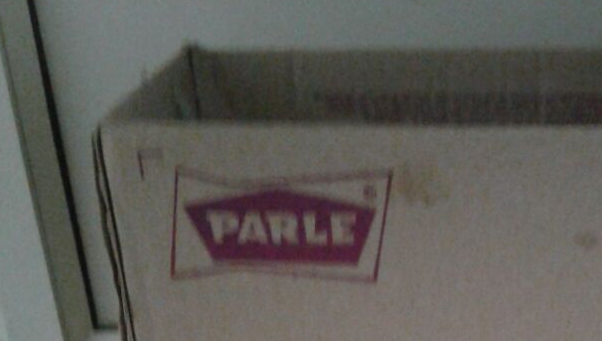

In [41]:
img = np.asarray(a)

Image.fromarray(img)

In [7]:
# def crop_objects(img, data, path, allowed_classes):

boxes, scores, classes, num_objects = 2,100,2,2
class_names = ['scheme','arrow']
#create dictionary to hold count of objects for image name
counts = dict()
for i in range(num_objects):
    # get count of class for part of image name
    class_index = int(classes[i])
    class_name = class_names[class_index]
    counts[class_name] = counts.get(class_name, 0) + 1
    # get box coords
    xmin, ymin, xmax, ymax = [i]
    # crop detection from image (take an additional 5 pixels around all edges)
    cropped_img = img[int(ymin)-5:int(ymax)+5, int(xmin)-5:int(xmax)+5]
    # construct image name and join it to path for saving crop properly
    img_name = class_name + '_' + str(counts[class_name]) + '.png'
    img_path = os.path.join("2.png", img_name )
    # save image
    cv2.imwrite(img_path, cropped_img)
    
        

TypeError: 'int' object is not subscriptable

In [8]:
img[int(ymin)-5:int(ymax)+5, int(xmin)-5:int(xmax)+5]

NameError: name 'ymin' is not defined